In [14]:
from dataclasses import dataclass
import plotly.express as px

import torch
from transformer_lens import HookedTransformer
import connectome.core as core
from connectome.interventions import (
        CorruptIntervention,
        CropIntervention,
        DampenIntervention,
        ZeroPattern,
)
from connectome.strategies import BasicStrategy
from connectome.plotting import attn_connectome, plot_graphviz_connectome
from connectome.metrics import logit_diff_metric

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Models
gpt2 = HookedTransformer.from_pretrained("gpt2-small")
attn_only_4l = HookedTransformer.from_pretrained("attn-only-4l")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer
Loaded pretrained model attn-only-4l into HookedTransformer


In [3]:
@dataclass
class Task:
    model: HookedTransformer
    prompt: str
    corrupted: list[str]
    correct: str
    incorrect: list[str]
    short_name: str

    @property
    def metric(self):
        return logit_diff_metric(self.model, self.correct, *self.incorrect)

    def tokens(self):
        return self.model.to_str_tokens(self.prompt)

    def pos_and_tokens(self):
        return [f"{i}: {t}" for i, t in enumerate(self.tokens())]

In [4]:
task_ioi_ABBA = Task(
    model=gpt2,
    prompt="When Mary and John went to the store, John gave a book to",
    correct=" Mary",
    incorrect=[" John"],
    corrupted=[
        "When Felix and Sarah went to the store, Diego gave a book to",
        "When Sarah and Felix went to the store, Felix gave a book to",
        "When Paul and John went to the store, John gave a book to",
        "When Mary and Felix went to the store, Diego gave a book to",
    ],
    short_name="ioi_abba",
)

task_ioi_BABA = Task(
    model=gpt2,
    prompt="When John and Mary went to the store, John gave a book to",
    correct=" Mary",
    incorrect=[" John"],
    corrupted=[
        "When Felix and Sarah went to the store, Diego gave a book to",
        "When Felix and Sarah went to the store, Felix gave a book to",
        "When John and Paul went to the store, John gave a book to",
        "When Diego and Mary went to the store, Felix gave a book to",
    ],
    short_name="ioi_baba",
)
task_docstring = Task(
    model=attn_only_4l,
    prompt='''def port(self, load, size, file, last):
    """oil column piece

    :param load: crime population
    :param size: unit dark
    :param''',
    correct=" file",
    incorrect=[" last", " load", " size", " self"],
    corrupted=[],  # TODO: fill in
    short_name="docstring 1",
)
task_docstring_2 = Task(
    model=attn_only_4l,
    prompt='''def run(place, nb, last, first):
    """run the place

    :param place: place to run
    :param nb: number of times to run
    :param''',
    correct=" first",
    incorrect=[" last", " place", " nb"],
    corrupted=[],  # TODO: fill in
    short_name="docstring 2",
)

In [5]:
TOP_K = 10
TASKS = [task_ioi_ABBA]

/home/felix/Repositories/connectome/connectome/interventions.py:126: UserWarning: The model does not use split qkv input. Setting it to True.
  warnings.warn("The model does not use split qkv input. Setting it to True.")


Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba
When Mary and John went to the store, John gave a book to
Correct:   Mary
Incorrect:  [' John']
Intervention:  ZeroPattern(0.0)


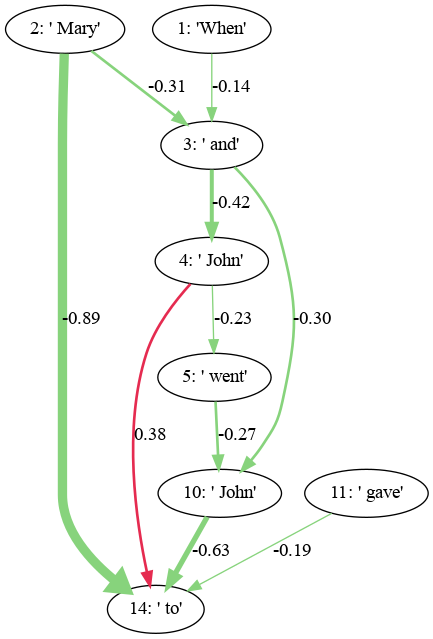

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba
When Mary and John went to the store, John gave a book to
Correct:   Mary
Incorrect:  [' John']
Intervention:  DampenIntervention(0.1)


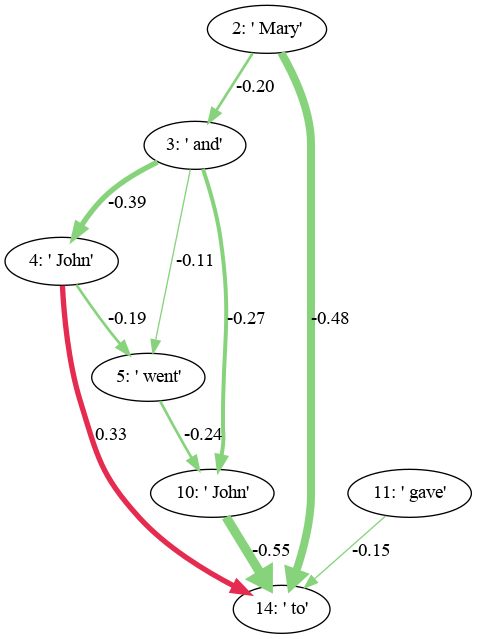

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba
When Mary and John went to the store, John gave a book to
Correct:   Mary
Incorrect:  [' John']
Intervention:  DampenIntervention(0.3)


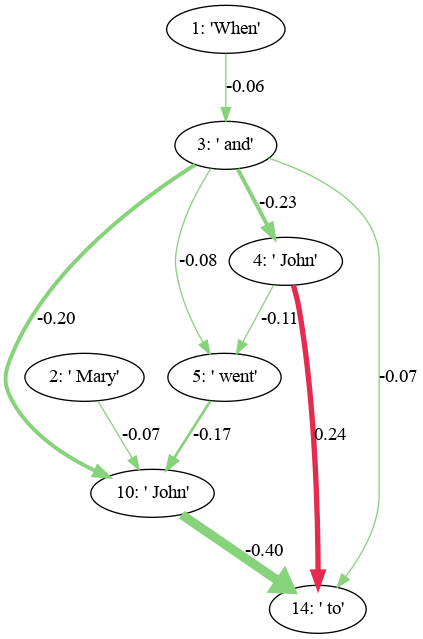

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba
When Mary and John went to the store, John gave a book to
Correct:   Mary
Incorrect:  [' John']
Intervention:  <CropIntervention(When Mary and John went to the store, John gave a book to)>


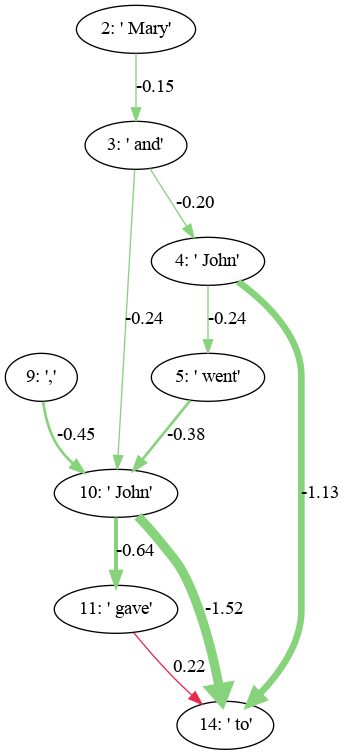

In [6]:
for task in TASKS:
    assert task.metric(task.model(task.prompt)[0]) > 0.1, "The model cannot do the task"
    interventions = [
        ZeroPattern(),
        DampenIntervention(0.1),
        DampenIntervention(0.3),
        CropIntervention(task.model, task.prompt),
    ]
    # for corrupted in task.corrupted:
    #     interventions.append(core.CorruptIntervention(task.model, task.prompt, corrupted))

    strategy = BasicStrategy()
    for intervention in interventions:
        connectome = core.connectome(
            task.model, task.prompt, task.metric, intervention, strategy
        )
        print(task.short_name)
        print(task.prompt)
        print("Correct: ", task.correct)
        print("Incorrect: ", task.incorrect)
        print("Intervention: ", intervention)
        plot_graphviz_connectome(task.model, task.prompt, connectome, top_k=TOP_K)

# Comparing Dampening Interventions

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.0


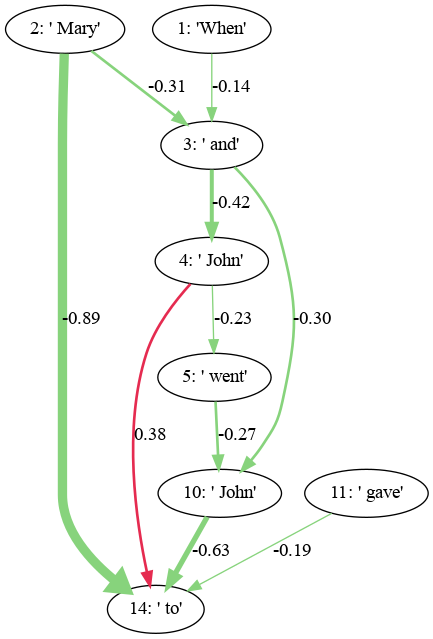

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.1


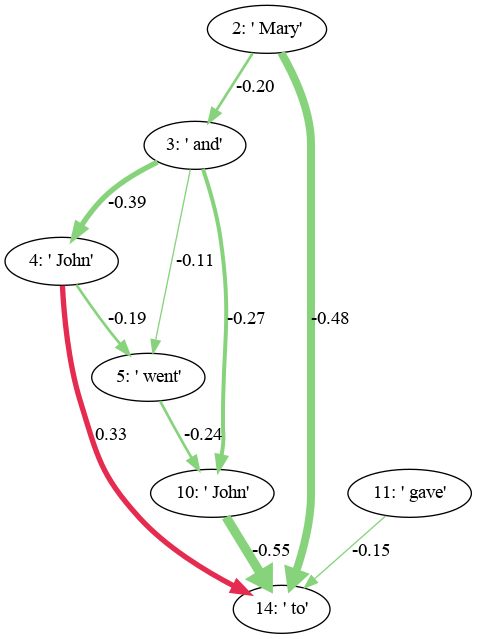

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.2


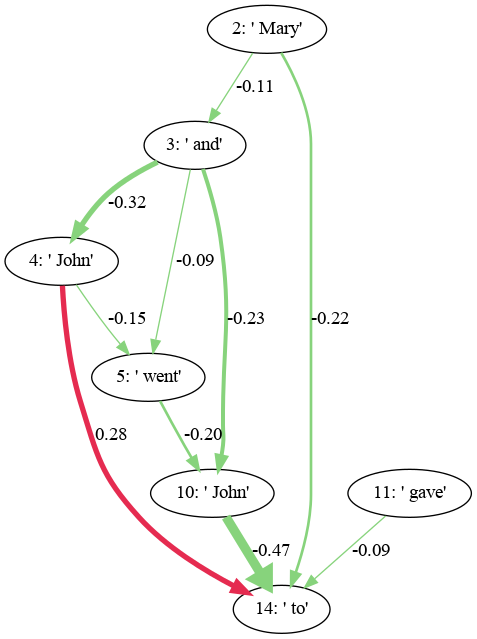

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.3


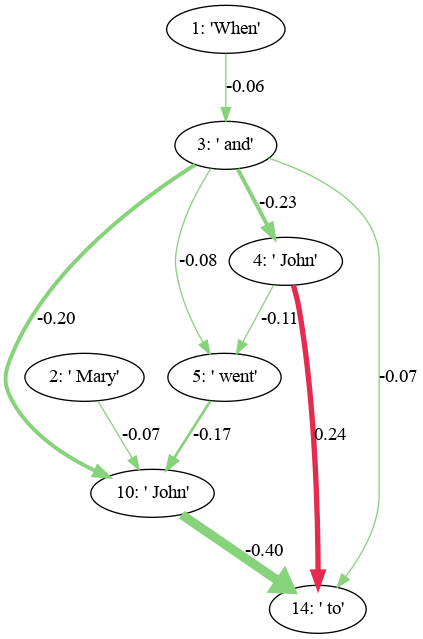

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.4


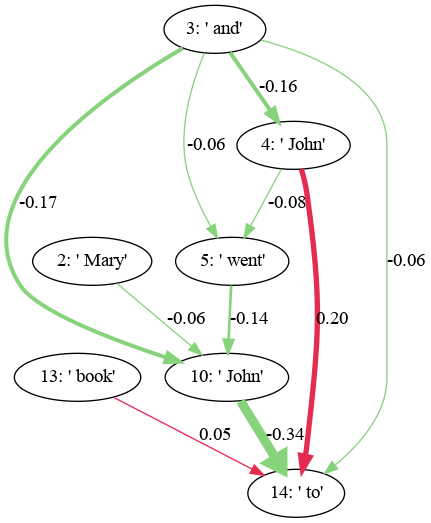

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.5


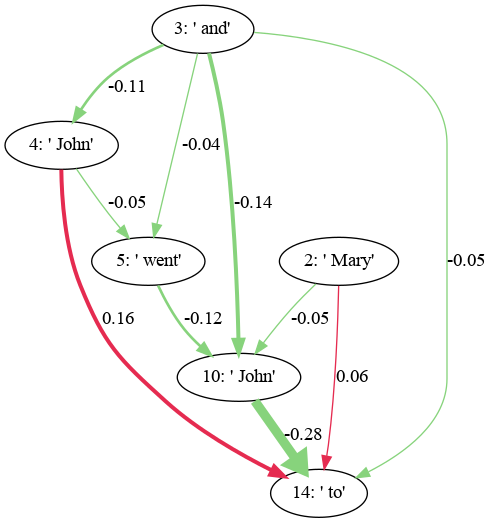

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.6


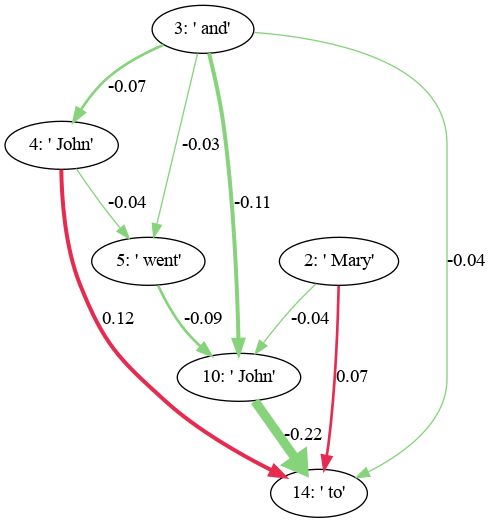

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.7


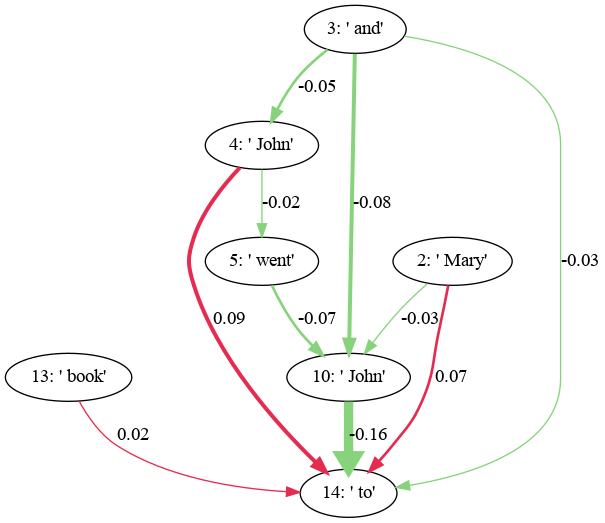

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.8


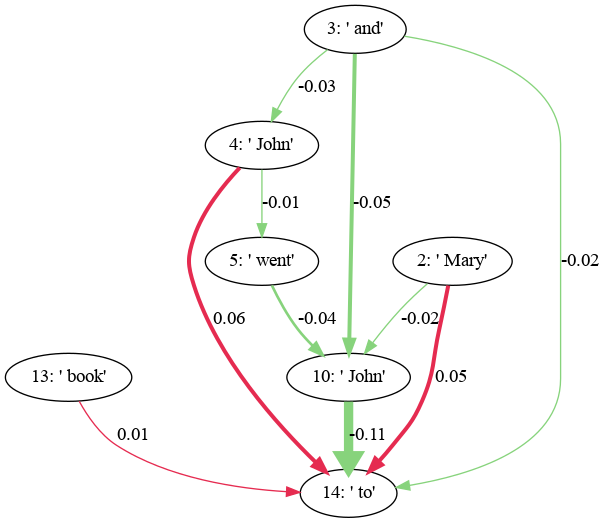

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 0.9


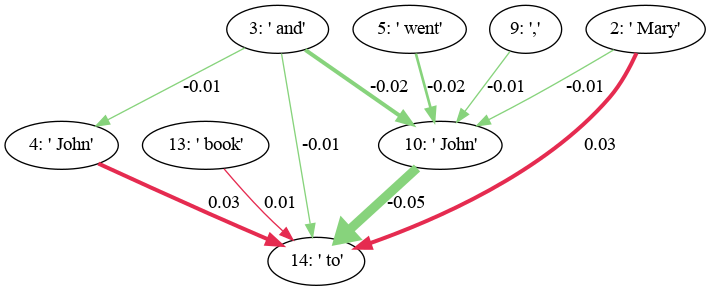

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening -1.0


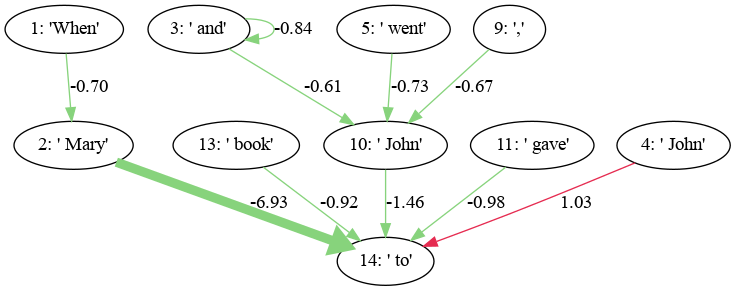

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening -0.5


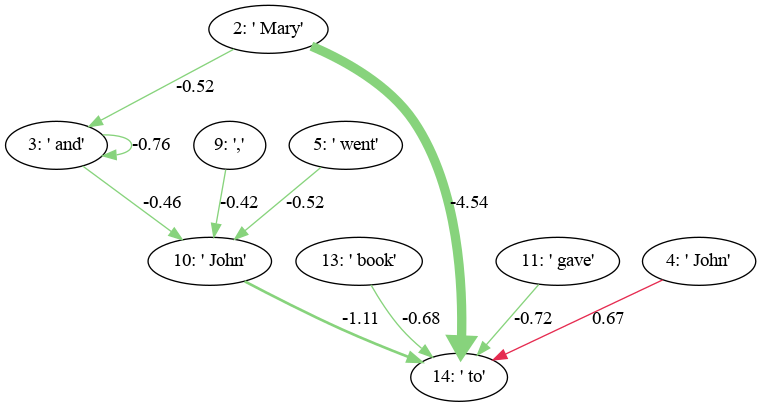

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 1.5


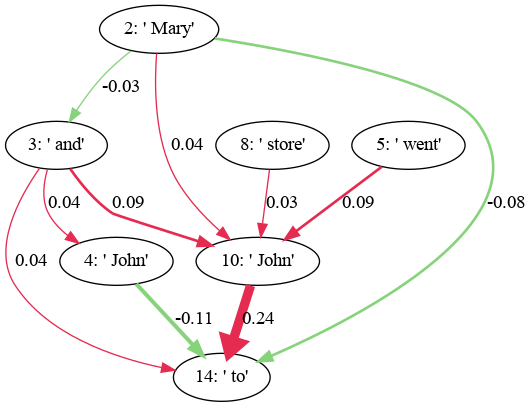

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba dampening 2.0


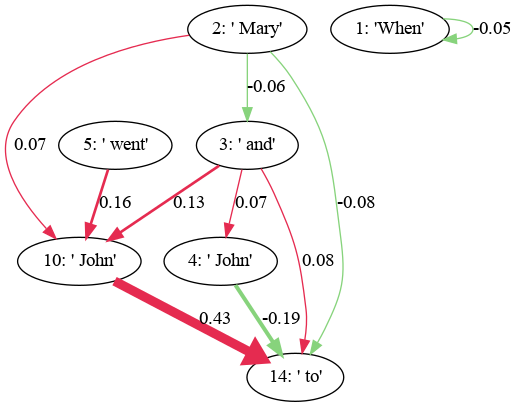

In [7]:
task = task_ioi_ABBA
connectomes = []
alphas = list(range(10)) + [-10, -5, 15, 20]
for alpha in alphas:
    intervention = DampenIntervention(alpha / 10)
    strategy = BasicStrategy()
    connectome = core.connectome(
        task.model, task.prompt, task.metric, intervention, strategy
    )
    connectomes.append(connectome)
    print(task.short_name, "dampening", alpha / 10)
    plot_graphviz_connectome(task.model, task.prompt, connectome, top_k=TOP_K)

In [10]:
var = torch.stack(
    [attn_connectome(task.model, task.prompt, c, fill=0) for c in connectomes]
)
# var = var / torch.linalg.matrix_norm(var, keepdim=True)
var = var / var.max(dim=2, keepdim=True).values.max(dim=1, keepdim=True).values
px.imshow(
    var.std(0),
    x=task.pos_and_tokens(),
    y=task.pos_and_tokens(),
    color_continuous_scale="Blues",
    title="Std. dev. of normalised connexions",
)

In [13]:
# ~Sanity check
for task in [task_ioi_ABBA, task_ioi_BABA]:
    _, cache = task.model.run_with_cache(task.prompt)
    avg_attention = (
        torch.stack(
            [
                cache["pattern", layer][0]  # remove batch dim
                for layer in range(task.model.cfg.n_layers)
            ]
        )
        .max(dim=0)
        .values.max(dim=0)
        .values
    )  # max over heads and layer

    px.imshow(
        avg_attention.cpu(),
        x=task.pos_and_tokens(),
        y=task.pos_and_tokens(),
        color_continuous_scale="Blues",
        title="Max attention on " + task.short_name,
    ).show()
    # %%

# Comparing contrastive connectomes

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba corrupt When Felix and Sarah went to the store, Diego gave a book to


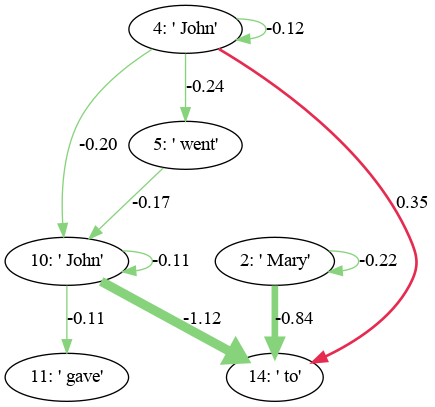

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba corrupt When Sarah and Felix went to the store, Felix gave a book to


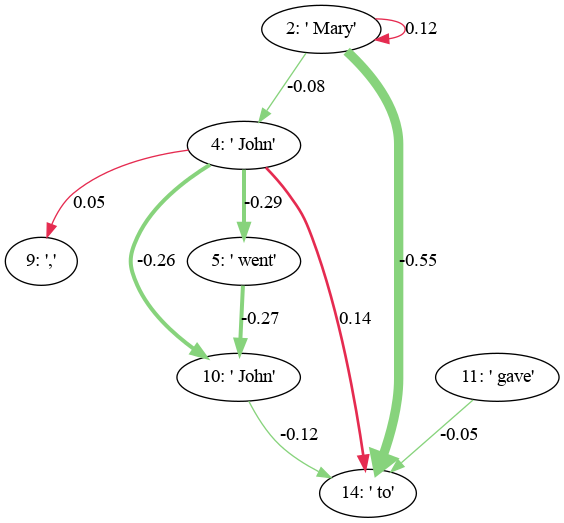

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba corrupt When Paul and John went to the store, John gave a book to


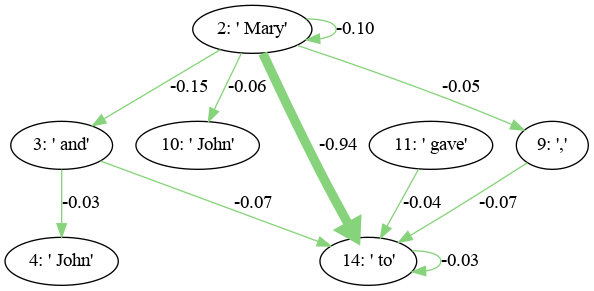

Baseline strength: 3.87


Exploring:   0%|          | 0/105 [00:00<?, ? connexions/s]

ioi_abba corrupt When Mary and Felix went to the store, Diego gave a book to


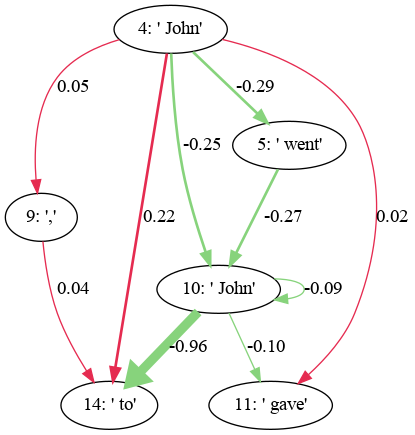

In [16]:
task = task_ioi_ABBA
for corrupt in task.corrupted:
    intervention = CorruptIntervention(task.model, task.prompt, corrupt)
    connectome = core.connectome(
        task.model, task.prompt, task.metric, intervention, BasicStrategy()
    )
    print(task.short_name, "corrupt", corrupt)
    plot_graphviz_connectome(task.model, task.prompt, connectome, top_k=TOP_K)